# 인공지능 팀 프로젝트

Title : Regression 알고리즘을 이용한 데이터 분석

Objective 1 : 중고차 가격 예측

Objective 2 : 보험료 가격 예측

# 중고차 가격 예측

## 1. Datasets

In [16]:
from __future__ import print_function
import os
data_path = ['data']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


In [17]:
import pandas as pd
import numpy as np

# Import the data using the file path
filepath = os.sep.join(data_path + ['car data.csv'])
data = pd.read_csv(filepath, sep=',')

print(data.shape)

(301, 9)


In [18]:
data.dtypes

Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Driven_kms         int64
Fuel_Type         object
Selling_type      object
Transmission      object
Owner              int64
dtype: object

총 301개의 데이터가 존재하며, 9개의 feature가 존재한다.

feature는 4개의 Categorical data와 5개의 numerical data로 이루어져 있다.

Linear Regression을 수행하기 위해서 Categorical data에 대해서 인코딩을 수행한다.

## 2. One-Hot Encoding

In [19]:
mask = data.dtypes == object
categorical_cols = data.columns[mask]

In [20]:
data[categorical_cols]

,Car_Name,Fuel_Type,Selling_type,Transmission
0,ritz,Petrol,Dealer,Manual
1,sx4,Diesel,Dealer,Manual
2,ciaz,Petrol,Dealer,Manual
3,wagon r,Petrol,Dealer,Manual
4,swift,Diesel,Dealer,Manual
...,...,...,...,...
296,city,Diesel,Dealer,Manual
297,brio,Petrol,Dealer,Manual
298,city,Petrol,Dealer,Manual
299,city,Diesel,Dealer,Manual


categorical 데이터가 ordered data인지, unordered data인지에 따라서 인코딩 기법이 다르다. 

현재 상황에서는 'Car_Name', 'Fuel Type', 'Selling_type', 'Transmission' 모두 순서가 있는 categorical data가 아니기 때문에 one-hot 인코딩을 수행한다.

In [21]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

101

In [22]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [23]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

101

In [24]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

9
5


In [25]:
data_ohc.head()

,Year,Selling_Price,Present_Price,Driven_kms,Owner,Car_Name_0,Car_Name_1,Car_Name_2,Car_Name_3,Car_Name_4,...,Car_Name_95,Car_Name_96,Car_Name_97,Fuel_Type_0,Fuel_Type_1,Fuel_Type_2,Selling_type_0,Selling_type_1,Transmission_0,Transmission_1
0,2014,3.35,5.59,27000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2013,4.75,9.54,43000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,2017,7.25,9.85,6900,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2011,2.85,4.15,5200,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,2014,4.60,6.87,42450,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## 3. Train & Test Split
- 학습용 데이터 셋과, 테스트용 데이터 셋을 7:3 비율로 나눈다.
- 먼저 simple linear regression을 적용해보고, 인코딩이 적절한지 확인한다.

In [26]:
y_col = 'Selling_Price'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [27]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [28]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,3.756862,1.130189
test,4.175031,4.723897


실험 결과를 보면, one-hot 인코딩의 경우 train 성능은 좋지만, test 성능이 나쁜것을 알 수 있다. 

이는 overfitting이 발생했기 때문이다. 

Scaler기법을 적용하여 overfitting을 완화한다.

In [29]:
pd.options.mode.chained_assignment = None

In [30]:
scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        4.175031
not_encoded - minmaxscaling          4.175031
not_encoded - maxabsscaling          4.175031
one_hot_encoded - standardscaling    4.723897
one_hot_encoded - minmaxscaling      4.723897
one_hot_encoded - maxabsscaling      4.723897
--------------------------------------------------------------------------------
not_encoded - standardscaling 4.175030852653918
not_encoded - minmaxscaling 4.175030852610068
not_encoded - maxabsscaling 4.175030852461687
one_hot_encoded - standardscaling 4.72389689756152
one_hot_encoded - minmaxscaling 4.723896897342971
one_hot_encoded - maxabsscaling 4.723896897586169


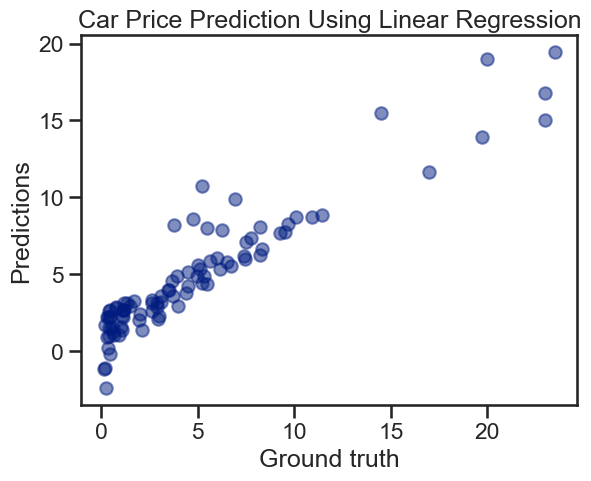

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');

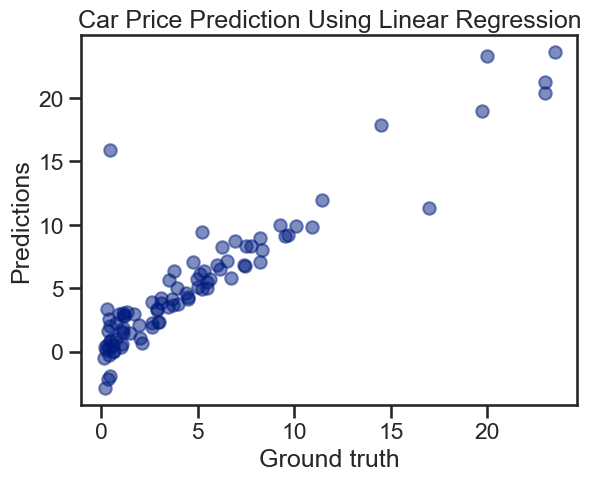

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, y_test_ohc_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Car Price Prediction Using Linear Regression');